# Google TimesFM model for predict today's tesla stock price (yejin)

- TimesFM (Time Series Foundation Model)
- reference 
: https://huggingface.co/google/timesfm-1.0-200m

* used python 3.11.11 in jupyter kernel on my mac

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from time import time
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [2]:
import timesfm
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32, 
          horizon_len=128, # predict 128 days into the future(2025,about 5 months)
          num_layers=50, 
          use_positional_embedding=False,
          context_len=500, # previous 500 days (because I'm using 500 days of data- 2023-2024)
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=128,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

# 1. Fetch stock data for TSLA

In [4]:
GetTSLA = yf.Ticker("TSLA")
# df=GetTSLA.history(period="max")

df = GetTSLA.history(start="2023-01-01", end="2024-12-31")
df.reset_index(inplace=True)  # Reset index to make "Date" a column

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03 00:00:00-05:00,118.470001,118.800003,104.639999,108.099998,231402800,0.0,0.0
1,2023-01-04 00:00:00-05:00,109.110001,114.589996,107.519997,113.639999,180389000,0.0,0.0
2,2023-01-05 00:00:00-05:00,110.510002,111.750000,107.160004,110.339996,157986300,0.0,0.0
3,2023-01-06 00:00:00-05:00,103.000000,114.389999,101.809998,113.059998,220911100,0.0,0.0
4,2023-01-09 00:00:00-05:00,118.959999,123.519997,117.110001,119.769997,190284000,0.0,0.0


In [5]:
# 2. Filter for 2023–2024 only
df_filtered = df[(df['Date'] >= '2023-01-01') & (df['Date'] <= '2024-12-31')].copy()
df_filtered.reset_index(drop=True, inplace=True)
print("total length:", len(df_filtered))

# 3. Extract the 'Close' prices as a numpy array
series = df_filtered['Close'].values

# 4. Wrap in a list to match TimeFM input format
forecast_input = [series]


# 5. Frequency info (you can just use [0] if only one series)
frequency_input = [0] # daily frequency


total length: 501


### 5. frequency input
In particular regarding the frequency, TimesFM expects a categorical indicator valued in {0, 1, 2}:

- 0 (default): high frequency, long horizon time series. We recommend using this for time series up to daily granularity.
- 1: medium frequency time series. We recommend using this for weekly and monthly data.
- 2: low frequency, short horizon time series. We recommend using this for anything beyond monthly, e.g. quarterly or yearly.
This categorical value should be directly provided with the array inputs. For dataframe inputs, we convert the conventional letter coding of frequencies to our expected categories, that

0: T, MIN, H, D(daily), B, U

1: W, M

2: Q(quarterly), Y

In [6]:
#6. Build input dataframe for TimesFM
# Create the dataframe in the format required by TimesFM
input_df = pd.DataFrame({
    "unique_id": ["TSLA"] * len(df),  # Use "TSLA" as the unique identifier
    "ds": df["Date"],                # Date column
    "y": df["Close"]                 # Closing price
})


# 7. Ensure y values are 1-dimensional
# Flatten y to ensure it is a 1D array
input_df["y"] = input_df["y"].values.flatten()


# 8. Forecast using TimesFM
# Pass the input dataframe to the TimesFM model for forecasting
forecast_df = tfm.forecast_on_df(
    inputs=input_df,  # Input dataframe
    freq="D",         # Daily frequency
    value_name="y",   # The column to predict
    num_jobs=-1       # Use all available cores for parallel processing
)

# 7. Display forecast results
print(forecast_df)


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].
Finished preprocessing dataframe.
Finished forecasting.
    unique_id                        ds     timesfm  timesfm-q-0.1  \
0        TSLA 2024-12-31 00:00:00-05:00  424.419800     401.746826   
1        TSLA 2025-01-01 00:00:00-05:00  427.736877     388.072937   
2        TSLA 2025-01-02 00:00:00-05:00  427.912476     380.316162   
3        TSLA 2025-01-03 00:00:00-05:00  428.294128     372.974060   
4        TSLA 2025-01-04 00:00:00-05:00  427.122314     364.235168   
..        ...                       ...         ...            ...   
123      TSLA 2025-05-03 01:00:00-04:00  373.090820     139.941284   
124      TSLA 2025-05-04 01:00:00-04:00  373.461121     141.332321   
125      TSLA 2025-05-05 01:00:00-04:00  367.8041

# TimesFM Forecast Interpretation
The forecast results include multiple columns that represent the predicted values and their uncertainty ranges. Here's how to interpret the key columns:


- timesfm: Median prediction (most likely value).

- timesfm-q-0.1: 10% quantile prediction (lower range of uncertainty).

- timesfm-q-0.5: 50% quantile prediction (equivalent to timesfm median).

- timesfm-q-0.9: 90% quantile prediction (higher range of uncertainty, if available).


<Example Interpretation: > 
For a given date (e.g., 2025-01-28):

- Median prediction (timesfm): 393.19 → The most likely stock price.

- 10% quantile (timesfm-q-0.1): 371.13 → Lower bound of the range.

- 50% quantile (timesfm-q-0.5): 393.19 → The central prediction (same as timesfm).

- 90% quantile: (if present) Higher bound of the range.

In [7]:
df_2025 = GetTSLA.history(start="2025-01-01", end="2025-12-31")
df_2025.reset_index(inplace=True)   # Reset index to make "Date" a column


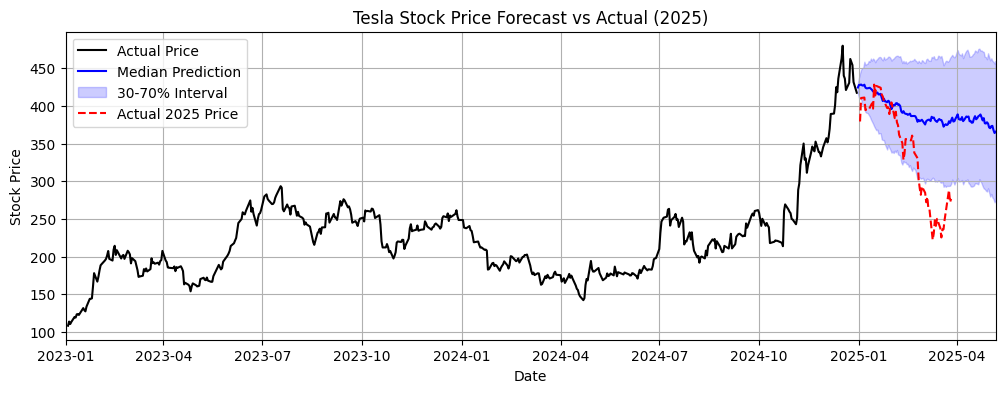

In [8]:
plt.figure(figsize=(12, 4))

# Actual price (전체)
plt.plot(df["Date"], df["Close"], label="Actual Price", color="black")

# Median prediction
plt.plot(forecast_df["ds"], forecast_df["timesfm"], label="Median Prediction", color="blue")

# Prediction interval
plt.fill_between(
    forecast_df["ds"],
    forecast_df["timesfm-q-0.3"],
    forecast_df["timesfm-q-0.7"],
    color="blue",
    alpha=0.2,
    label="30-70% Interval"
)

# Actual price after forecast (2025)
plt.plot(df_2025["Date"], df_2025["Close"], label="Actual 2025 Price", color="red", linestyle="--")

# x-axis range
start_date = pd.to_datetime("2023-01-01")
end_date = forecast_df["ds"].max()
plt.xlim([start_date, end_date])

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price Forecast vs Actual (2025)")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


merged = pd.merge(
    forecast_df,
    df_2025,
    left_on="ds",     # prediction date
    right_on="Date"   # actual date
)

y_pred = merged["timesfm"]
y_true = merged["Close"]

# merged.head()


In [10]:
# MAE
mae = mean_absolute_error(y_true, y_pred)

# MSE
mse = mean_squared_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mse)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE:  39.17
MSE:  2699.70
RMSE: 51.96


In [ ]:
#load pickle file 
import pickle

with open("results_matrix.pkl","rb") as f:
    matrix = pickle.load(f)
    
matrix

matrix.loc["timesfm"] = [mae, mse, rmse]

matrix 

In [25]:
# save matrix to pickle file
with open("results_matrix.pkl", "wb") as f:
    pickle.dump(matrix, f)

# Predicting Tomorrow's TSLA stock price

In [12]:
from datetime import datetime, timedelta

# Generate the next day's datetime
today = datetime.today()
tmr = (today + timedelta(days=1)).date()  

# Ensure both tmr and forecast_df["ds"] are datetime
forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])  # Convert to datetime
filtered_df = forecast_df[forecast_df["ds"].dt.date == tmr]  # Compare dates directly

print(filtered_df)

   unique_id                        ds     timesfm  timesfm-q-0.1  \
86      TSLA 2025-03-27 01:00:00-04:00  380.868469     174.604492   

    timesfm-q-0.2  timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  \
86     247.964783     296.630859     343.127747     380.868469     422.053955   

    timesfm-q-0.7  timesfm-q-0.8  timesfm-q-0.9  
86     465.782837     523.067627     605.293091  


In [13]:
print(tmr)

2025-03-27
